In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
tweet=pd.read_csv('Tweets.csv')

In [3]:
tweet.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [4]:
tweet.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


In [5]:
tweet=tweet.drop(columns='selected_text', axis=1)
tweet=tweet.drop(columns='textID', axis=1)

In [6]:
tweet.isnull().sum()

text         1
sentiment    0
dtype: int64

In [7]:
tweet['text'].fillna(tweet['text'].mode()[0], inplace=True)

In [8]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27481 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [9]:
x,y = tweet['text'], tweet['sentiment']

In [10]:
print (x)
print(y)

0                      I`d have responded, if I were going
1            Sooo SAD I will miss you here in San Diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         Sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on Denver  husband l...
27477     I`ve wondered about rake to.  The client has ...
27478     Yay good for both of you. Enjoy the break - y...
27479                           But it was worth it  ****.
27480       All this flirting going on - The ATG smiles...
Name: text, Length: 27481, dtype: object
0         neutral
1        negative
2        negative
3        negative
4        negative
           ...   
27476    negative
27477    negative
27478    positive
27479    positive
27480     neutral
Name: sentiment, Length: 27481, dtype: object


In [11]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
# Check number of samples in train and test
print('Train samples: ',len(x_train))
print('Test samples: ',len(x_test))
print(x_train)
print(x_test)
print(y_train)
print(y_test)

Train samples:  21984
Test samples:  5497
11293                              Doctor Who has finished
11299                                          you should.
18204    back at school again. almost weekend. oh wait,...
22728    My computer is SO slooowww this morning.  I th...
1231                             On my way to dazzle bar!!
                               ...                        
21575    STAR TREK WAS PURE AWESOME! LOVE IT!!! <3333  ...
5390     Will be going to Indiana Baptist Sunday, Pray ...
860      is sitting thru the boring bits in Titanic wai...
15795                                      Missed the play
23654    Oh I`m really tired of these migraines! #Endom...
Name: text, Length: 21984, dtype: object
1588      WOOOOOOOOOO   are you coming to Nottingham at...
23879                   resting had a whole day of walking
6561     was in Palawan a couple of days ago, i`ll try ...
2602      I know! I`m so slow its horrible. DON`T TELL ...
4003     Glad I went out, glad I

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [13]:
def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train.astype(str):
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    # tokenize
    final_list_train,final_list_test = [],[]

    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)]
                                     for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [2 if label == 'neutral' else 1 if label == 'positive' else 0 for label in y_train]
    encoded_test = [2 if label == 'neutral' else 1 if label == 'positive' else 0 for label in y_val]

    #print(encoded_test)
    #print(final_list_train)
    #print(encoded_train)
    #print(final_list_test)
    #return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    return np.asarray(final_list_train,dtype=object),np.array(encoded_train),np.asarray(final_list_test,dtype=object),np.array(encoded_test),onehot_dict

In [14]:
print(x_train)

11293                              Doctor Who has finished
11299                                          you should.
18204    back at school again. almost weekend. oh wait,...
22728    My computer is SO slooowww this morning.  I th...
1231                             On my way to dazzle bar!!
                               ...                        
21575    STAR TREK WAS PURE AWESOME! LOVE IT!!! <3333  ...
5390     Will be going to Indiana Baptist Sunday, Pray ...
860      is sitting thru the boring bits in Titanic wai...
15795                                      Missed the play
23654    Oh I`m really tired of these migraines! #Endom...
Name: text, Length: 21984, dtype: object


In [15]:
X_train, Y_train, X_test, Y_test,vocab_dict = tokenize(x_train,y_train,x_test,y_test)
X_train.size

21984

In [16]:
np.asarray(x_train, dtype=object)

array(['Doctor Who has finished', ' you should.',
       'back at school again. almost weekend. oh wait, i gotta work from eight to four tonight',
       ...,
       'is sitting thru the boring bits in Titanic waiting for the good bit to start in couple of hours',
       'Missed the play',
       'Oh I`m really tired of these migraines! #Endometriosis & #Fibromyalgia & #Migraines & sleep probs just compoundin ea other since surgery'],
      dtype=object)

In [17]:
vocab_dict

{'im': 1,
 'day': 2,
 'good': 3,
 'get': 4,
 'like': 5,
 'go': 6,
 'dont': 7,
 'work': 8,
 'love': 9,
 'today': 10,
 'going': 11,
 'got': 12,
 'cant': 13,
 'happy': 14,
 'one': 15,
 'u': 16,
 'lol': 17,
 'time': 18,
 'know': 19,
 'back': 20,
 'really': 21,
 'see': 22,
 'home': 23,
 'well': 24,
 'night': 25,
 'new': 26,
 'want': 27,
 'mothers': 28,
 'still': 29,
 'think': 30,
 'oh': 31,
 'much': 32,
 'thanks': 33,
 'miss': 34,
 'great': 35,
 'last': 36,
 'hope': 37,
 'haha': 38,
 'need': 39,
 'morning': 40,
 'thats': 41,
 'ill': 42,
 'fun': 43,
 'feel': 44,
 'twitter': 45,
 'would': 46,
 'tomorrow': 47,
 'wish': 48,
 'sad': 49,
 'tonight': 50,
 'sorry': 51,
 'bad': 52,
 'didnt': 53,
 'right': 54,
 'make': 55,
 'nice': 56,
 'gonna': 57,
 'yeah': 58,
 'though': 59,
 'week': 60,
 'way': 61,
 'better': 62,
 'weekend': 63,
 'sleep': 64,
 'ive': 65,
 'come': 66,
 'getting': 67,
 'could': 68,
 'bed': 69,
 'next': 70,
 'people': 71,
 'youre': 72,
 'watching': 73,
 'days': 74,
 'hate': 75,
 'wai

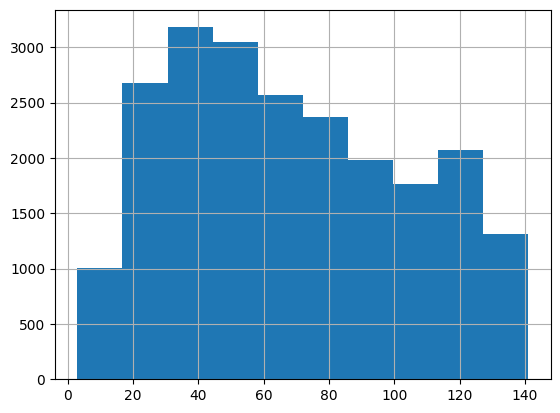

count    21984.000000
mean        68.230941
std         35.618273
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
dtype: float64

In [18]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [19]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


In [20]:
#Doing so that the test does'nt go over 500 words
x_train_pad = padding_(X_train, 500)
x_test_pad = padding_(X_test, 500)

In [21]:
train_data = TensorDataset(torch.from_numpy(x_train_pad),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad),torch.from_numpy(Y_test))

In [22]:
batch_size = 48

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
len

<function len(obj, /)>

In [23]:
import torch.nn.functional as F

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_dim, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()

        self.output_dim = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.drop_prob = drop_prob

        # Embedding and LSTM Layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)

        # Dropout Layer
        self.dropout = nn.Dropout(0.3)

        # Linear Layer (Output Layer) for Multi-Class Classification
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Take the last time step output from the LSTM
        lstm_out = lstm_out[:, -1, :]

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # softmax function for multi-class classification
        softmax_out = F.softmax(out, dim=1)

        return softmax_out, hidden



    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
        hidden = (h0, c0)
        return hidden


In [24]:
# Define Model Hyperparameters
embedding_dim = 64
hidden_dim = 256
n_layers = 2
output_dim = 3

# Instantiate the model w/ hyperparams
vocab_size = len(vocab_dict)+1 # +1 for the 0 padding + our word tokens

model = SentimentLSTM(vocab_size, output_dim, embedding_dim, hidden_dim, n_layers)

In [25]:
# Training Loop for the model

# Loss and Optimization functions

lr = .001
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [26]:
steps_per_epoch = len(train_loader)
print("Number of steps per epoch:", steps_per_epoch)

Number of steps per epoch: 458


In [27]:
#Here is where the model is load. Change the name if necessary

model = torch.load('mymodel (7).pth')

In [28]:
#This is where we trained our model
"""import torch.optim as optim

num_classes = 3

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 2
clip = 5

train_losses = []
train_acc = []

for e in range(epochs):
    model.train()
    steps = 0

    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        steps += 1
        h = tuple([each.data for each in h])

        inputs = inputs.type(torch.LongTensor)
        labels = labels.view(-1)

        # Ensure that labels have the correct data type
        labels = labels.type(torch.long)

        output, h = model(inputs, h)

        optimizer.zero_grad()

        # Ensure that the criterion (CrossEntropyLoss) is appropriate for the task
        loss = criterion(output, labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        # Calculate accuracy for multi-class classification
        _, predicted = torch.max(output, 1)
        correct = (predicted == labels).float()
        accuracy = correct.mean()
        train_acc.append(accuracy.item())

        if (steps ==2) or (steps==50) or (steps==100) or (steps==150) or (steps==200) or (steps==250) or (steps==300) or (steps == 350) or (steps == 400):
           torch.save(model, 'mymodel.pth')

        print("Epoch: {}/{}...".format(e+1, epochs),
          "Step: {}...".format(steps),
          "Loss: {:.6f}...".format(loss.item()),
          "Acc: {:.6f}".format(accuracy))



print("DONE TRAINING")
"""

'import torch.optim as optim\n\n# Assuming you have three classes: \'positive\', \'negative\', \'neutral\'\nnum_classes = 3\n\n# Assuming you have initialized your SentimentLSTM model and created a DataLoader named train_loader\n\n# Loss function for multi-class classification\ncriterion = nn.CrossEntropyLoss()\n\n# Optimizer (choose an appropriate one for your task)\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\nepochs = 2\nclip = 5\n\ntrain_losses = []\ntrain_acc = []\n\nfor e in range(epochs):\n    model.train()\n    steps = 0\n\n    h = model.init_hidden(batch_size)\n\n    for inputs, labels in train_loader:\n        steps += 1\n        h = tuple([each.data for each in h])\n\n        inputs = inputs.type(torch.LongTensor)\n\n        # Ensure that labels have the same batch size as the model\'s output\n        labels = labels.view(-1)  # Flatten the labels if needed\n\n        # Ensure that labels have the correct data type\n        labels = labels.type(torch.long)\n\n    

In [29]:
# Evaluation on the test set
model.eval()

test_losses = []
test_correct = 0
test_total = 0

for inputs, labels in test_loader:
    batch_size = inputs.size(0)

    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])

    inputs = inputs.type(torch.LongTensor)
    output, test_h = model(inputs, test_h)

    # Update loss function to handle three classes
    labels_one_hot = F.one_hot(labels, num_classes=3).float()
    test_loss = loss_function(output.squeeze(), labels_one_hot)
    test_losses.append(test_loss.item())

    # Calculate accuracy
    _, predicted_classes = output.max(1)  # Get the index of the max log-probability
    test_correct += torch.sum(predicted_classes == labels).item()
    test_total += batch_size

test_accuracy = (test_correct / test_total) * 100.0
print("Test Loss: {:.3f}...".format(np.mean(test_losses)),
      "Test Acc: {:.3f}%".format(test_accuracy))


Test Loss: 0.977... Test Acc: 61.688%


In [62]:
# Evaluation on the train set
model.eval()

train_losses = []
train_correct = 0
train_total = 0

for inputs, labels in train_loader:
    batch_size = inputs.size(0)

    # Initialize hidden state
    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])

    inputs = inputs.type(torch.LongTensor)
    output, test_h = model(inputs, test_h)

    # Update loss function to handle three classes
    labels_one_hot = F.one_hot(labels, num_classes=3).float()
    train_loss = loss_function(output.squeeze(), labels_one_hot)
    train_losses.append(train_loss.item())

    # Calculate accuracy
    _, predicted_classes = output.max(1)  # Get the index of the max log-probability
    train_correct += torch.sum(predicted_classes == labels).item()
    train_total += batch_size

train_accuracy = (train_correct / train_total) * 100.0
print("Train Loss: {:.3f}...".format(np.mean(train_losses)),
      "Train Acc: {:.3f}%".format(train_accuracy))


Train Loss: 0.909... Train Acc: 63.537%


In [61]:
#Show the model
print(model)


SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [60]:
#Model Printing out with test exemples

import torch
from torchtext.data.utils import get_tokenizer

model.eval()

def tokenize_input(sentence, tokenizer):
    return tokenizer(sentence.lower())

# Write here the input test sentences
input_sentences = [
    "I love this movie!",
    "This is a terrible film.",
    "The movie is neither good nor bad.",
    "Sooo SAD I will miss you here in San Diego!!!"
    ,"I Love you"
]

tokenizer = get_tokenizer("basic_english")

# Process input sentences and make predictions
class_labels = ['negative','positive', 'neutral']

for sentence in input_sentences:
    tokenized_sentence = tokenize_input(sentence, tokenizer)

    indices = [vocab_dict[token] for token in tokenized_sentence if token in vocab_dict]

    if not indices:
        print(f"Skipping empty indices for input: {sentence}")
        continue

    input_tensor = torch.LongTensor(indices).unsqueeze(0)
    hidden = model.init_hidden(1)

    with torch.no_grad():
        output, _ = model(input_tensor, hidden)
    _, predicted_class = torch.max(output, 1)
    predicted_sentiment = class_labels[predicted_class.item()]

    print(f"Input: {sentence}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print("=" * 50)

Input: I love this movie!
Predicted Sentiment: positive
Input: This is a terrible film.
Predicted Sentiment: positive
Input: The movie is neither good nor bad.
Predicted Sentiment: positive
Input: Sooo SAD I will miss you here in San Diego!!!
Predicted Sentiment: negative
Input: I Love you
Predicted Sentiment: positive
